In [249]:
# !pip install scikit-learn

### Imports

In [250]:
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

random.seed(777)

### Normal Timeseries

In [251]:
# Observations
def observations(initial=100, final=110, observations=100, times=10):
  aux = list()
  for i in range(times):
    aux.append([random.randint(initial, final) for i in range(observations)])
  return np.array(aux)

# Drift
def drift(data, times=1, step=10, window=10):
  aux = list()
  last = data[-1]
  observations = len(last)
  q25 = np.quantile(last, 0.25)
  initial = int(q25)
  for i in range(times):
    aux.append([random.randint(initial, initial + window) for i in range(observations)])
    initial += step

  data = np.append(data, np.array(aux), axis=0)
  return data

# Outliers
def outliers(data, times=5):
  iqr = stats.iqr(data)
  q25 = np.quantile(data, 0.25)
  q75 = np.quantile(data, 0.75)

  upper_bound = q75 + (1.5 * iqr)
  lower_bound = q25 - (1.5 * iqr)

  for i in range(times):
    data[random.randint(0, len(data)-1)] = random.choice([upper_bound + iqr, lower_bound - iqr])

  return data

# Basic Outlier Detector
def outlierDetector(data):
  iqr = stats.iqr(data)
  q25 = np.quantile(data, 0.25)
  q75 = np.quantile(data, 0.75)
  upper_bound = q75 + (1.5 * iqr)
  lower_bound = q25 - (1.5 * iqr)

  return np.where((data > upper_bound) | (data < lower_bound) , True, False)

def getOutlierDetectorParams(data):
  iqr = stats.iqr(data)
  q25 = np.quantile(data, 0.25)
  q75 = np.quantile(data, 0.75)
  upper_bound = q75 + (1.5 * iqr)
  lower_bound = q25 - (1.5 * iqr)

  return iqr, q25, q75, upper_bound, lower_bound

# Z-Score Outlier Detector
def outlierDetectorZscore(data, threshold=3):
  z = np.abs(stats.zscore(data))
  return np.where(z > threshold, True, False)

Normal Data

In [252]:
batch_size = 15

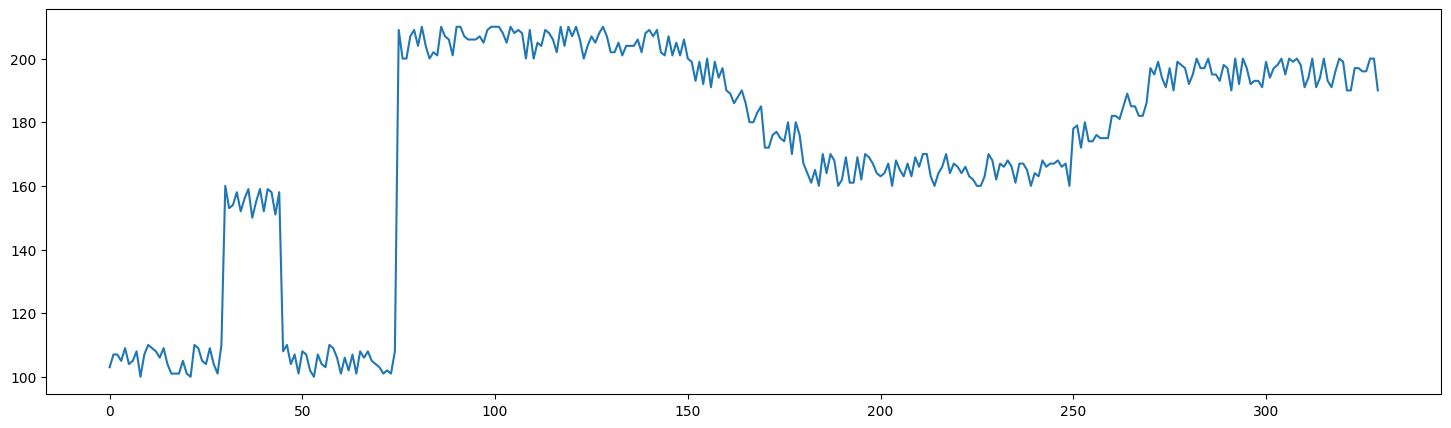

In [253]:
data = observations(times=2, observations=batch_size)

drift_1 = observations(times=1, initial=150, final=160, observations=batch_size) # Sudden drift
drift_2 = observations(times=2, observations=batch_size) # Back to normal
drift_3 = observations(times=5, initial=200, final=210, observations=batch_size) # Sudden drift

drift_4 = np.array([
    np.array([random.randint(190, 200) for i in range(10)]),
    np.array([random.randint(180, 190) for i in range(10)]),
    np.array([random.randint(170, 180) for i in range(10)])
]).reshape(2,15) # Gradual drift

drift_5 = observations(initial=160, final=170, times=4, observations=batch_size)

drift_6 = np.array([
    np.array([random.randint(160, 170) for i in range(10)]),
    np.array([random.randint(170, 180) for i in range(10)]),
    np.array([random.randint(180, 190) for i in range(10)])
]).reshape(2,15) # Gradual drift

drift_7 = observations(initial=190, final=200, times=4, observations=batch_size)


data = np.concatenate((data, drift_1), axis=0)
data = np.concatenate((data, drift_2), axis=0)
data = np.concatenate((data, drift_3), axis=0)
data = np.concatenate((data, drift_4), axis=0)
data = np.concatenate((data, drift_5), axis=0)
data = np.concatenate((data, drift_6), axis=0)
data = np.concatenate((data, drift_7), axis=0)

aux = data.flatten()

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(aux)
plt.show()

Outliers

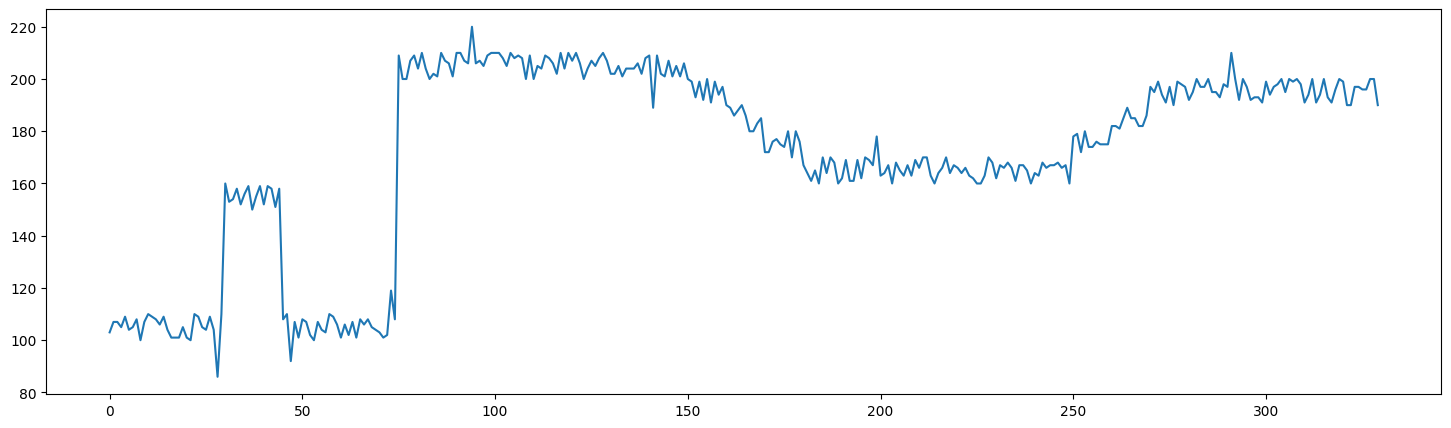

In [254]:
data[1] = outliers(data[1], times=1)
data[3] = outliers(data[3], times=1)
data[4] = outliers(data[4], times=1)
data[6] = outliers(data[6], times=1)
data[9] = outliers(data[9], times=1)
data[13] = outliers(data[13], times=1)
data[19] = outliers(data[19], times=1)

aux = data.flatten()

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(aux)
plt.show()

Detect Outliers

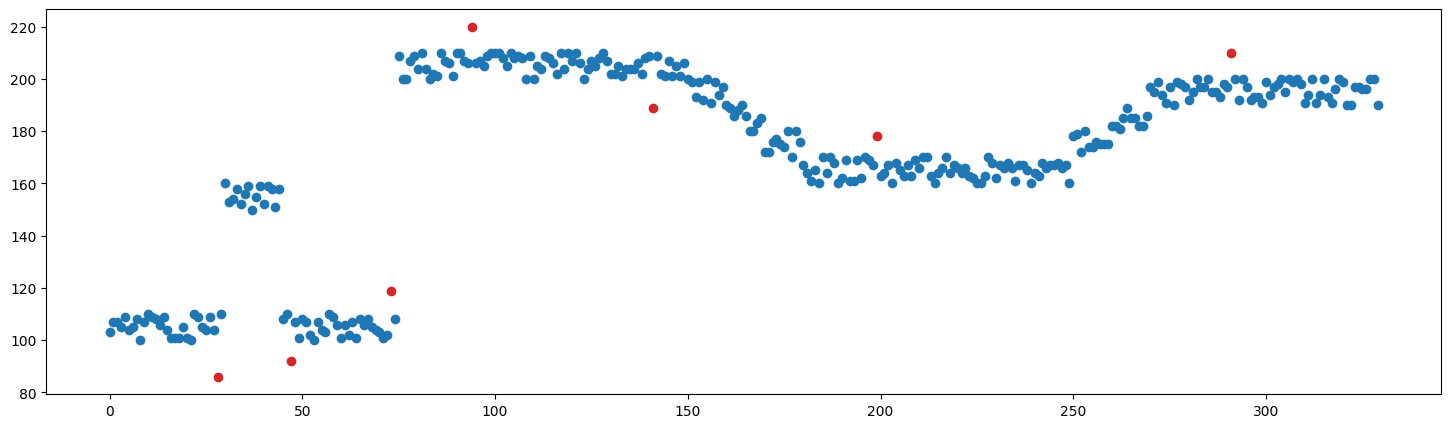

In [255]:
# IQR

fig, ax = plt.subplots(figsize=(18, 5))
outliers = []

for d in range(len(data)):
  outliers.append(outlierDetector(data[d]))

aux = data.flatten
aux_outliers = np.array(outliers).flatten()

for i, value in enumerate(aux()):
  color = '#d62728' if aux_outliers[i] else '#1f77b4'
  ax.plot(i, value, marker='o', color=color)

plt.show()

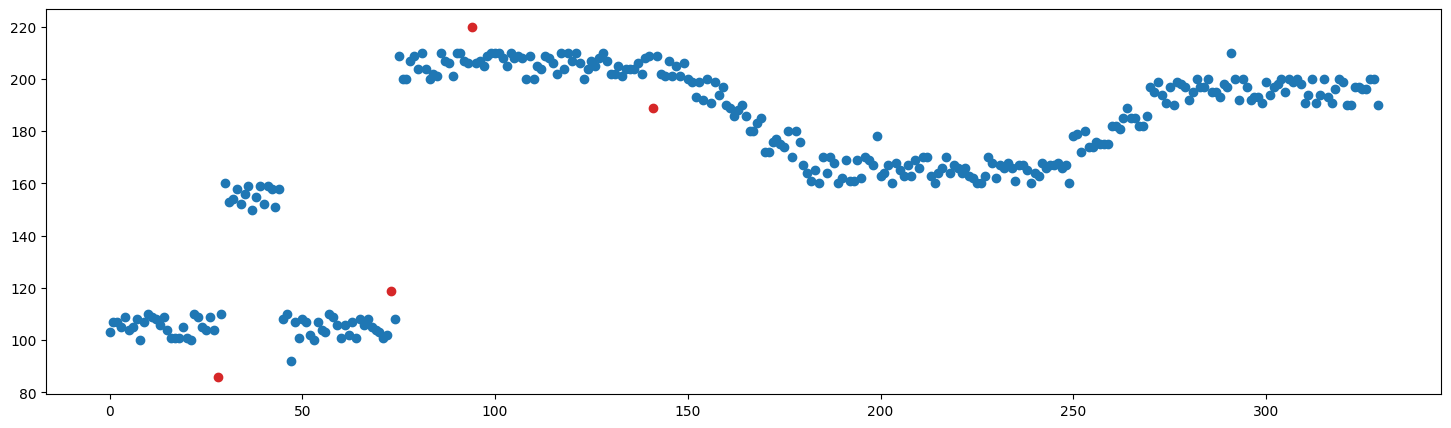

In [256]:
# Z-Score

fig, ax = plt.subplots(figsize=(18, 5))
outliers = []

for d in range(len(data)):
  outliers.append(outlierDetectorZscore(data[d]))

aux = data.flatten
aux_outliers = np.array(outliers).flatten()

for i, value in enumerate(aux()):
  color = '#d62728' if aux_outliers[i] else '#1f77b4'
  ax.plot(i, value, marker='o', color=color)

plt.show()

### Implement Detectors

#### DBSCAN

_Dificuldade ao trabalhar com o DBSCAN_
- Como definir o min_samples? 

In [257]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

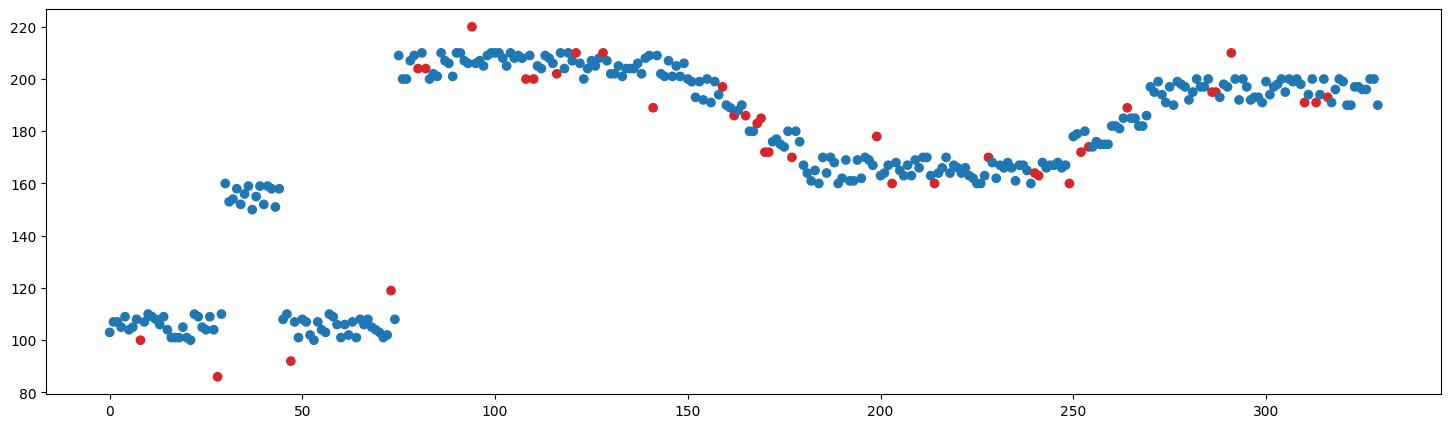

In [258]:
clusters = np.array([])

for d in data:
  X = d.reshape(-1, 1)
  dbscan = DBSCAN(eps=1, min_samples=3)
  clusters_aux = dbscan.fit_predict(X)
  if clusters.shape[0] == 0:
    clusters = clusters_aux
  else:
    clusters = np.append(clusters, clusters_aux, axis=0)

fig, ax = plt.subplots(figsize=(18, 5))

color = ['#d62728' if cl == -1 else '#1f77b4' for cl in clusters]
flat = data.flatten()

ax.scatter(range(len(flat)), flat, c=color, marker='o')

plt.show()

#### IFO

In [259]:
from sklearn.ensemble import IsolationForest

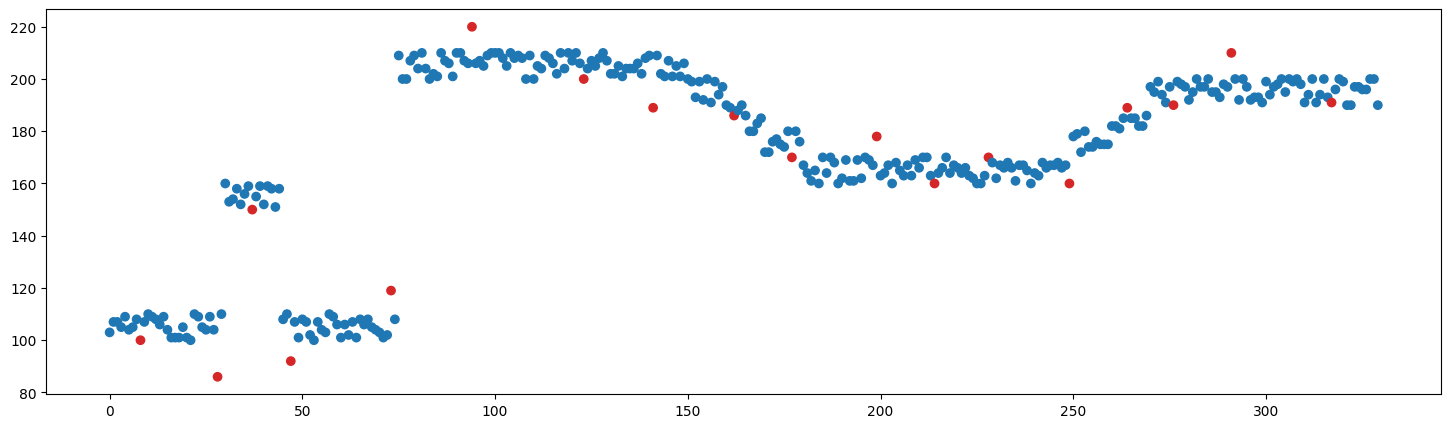

In [260]:
iso = IsolationForest(contamination=0.05, random_state=777)

predictions = np.array([])

for d in data:
  X = d.reshape(-1,1)
  iso.fit(X)
  predictions_aux = iso.predict(X)
  if predictions.shape[0] == 0:
    predictions = predictions_aux
  else:
    predictions = np.append(predictions, predictions_aux, axis=0)

fig, ax = plt.subplots(figsize=(18, 5))

color = ['#d62728' if p == -1 else '#1f77b4' for p in predictions]
flat = data.flatten()

ax.scatter(range(len(flat)), flat, c=color, marker='o')

plt.show()

#### ADWIN

In [261]:
from river import drift

In [262]:
adwin = drift.ADWIN()

flat = data.flatten()

drifts = np.array([])

for d in flat:
  adwin.update(d)

  if adwin.drift_detected:
    drifts = np.append(drifts, 1)
  else:
    drifts = np.append(drifts, 0)

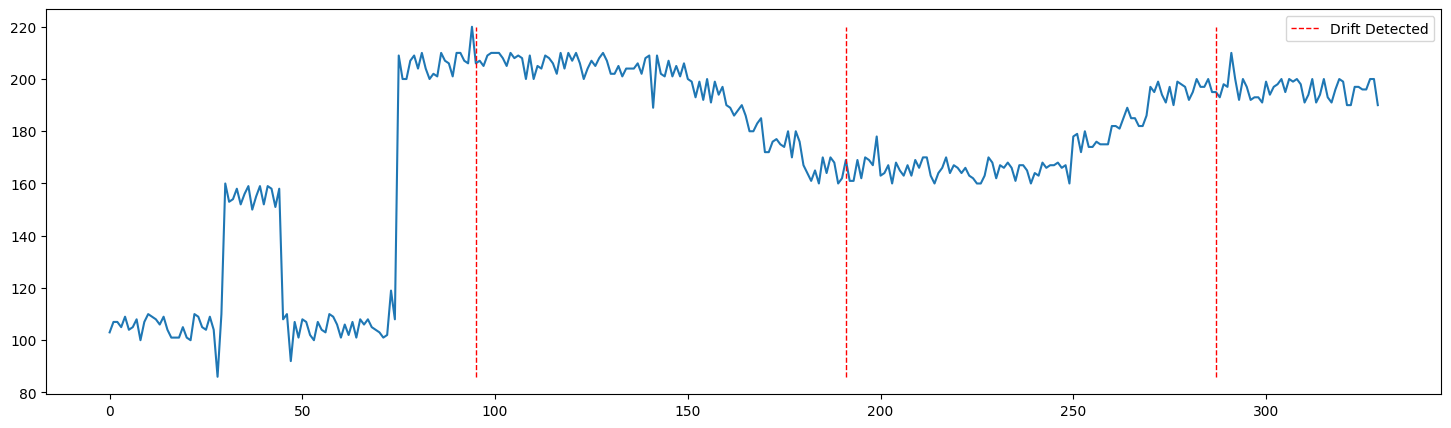

In [263]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(flat)

lines = np.where(drifts == 1)[0]
ax.vlines(lines, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

### Linear Regression

In [264]:
from sklearn.linear_model import LinearRegression

flat = data.flatten()

X = flat[:-1].reshape(-1,1)
y = flat[1:]

X_train = X[:100]
y_train = y[:100]

X_test = X[100:]
y_test = y[100:]

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

error = 1 - (predictions / y_test)

### DDM

In [265]:
from river.drift.binary import DDM, EDDM

ddm = DDM()
correct = (error > 0.1).astype(int)

warns = np.array([0 for i in range(101)])
drifts = np.array([0 for i in range(101)])

for i, c in enumerate(correct):
    ddm.update(c)
    if ddm.warning_detected:
        warns = np.append(warns, 1)
    else:
        warns = np.append(warns, 0)
    if ddm.drift_detected:
        drifts = np.append(drifts, 1)
    else:
        drifts = np.append(drifts, 0)

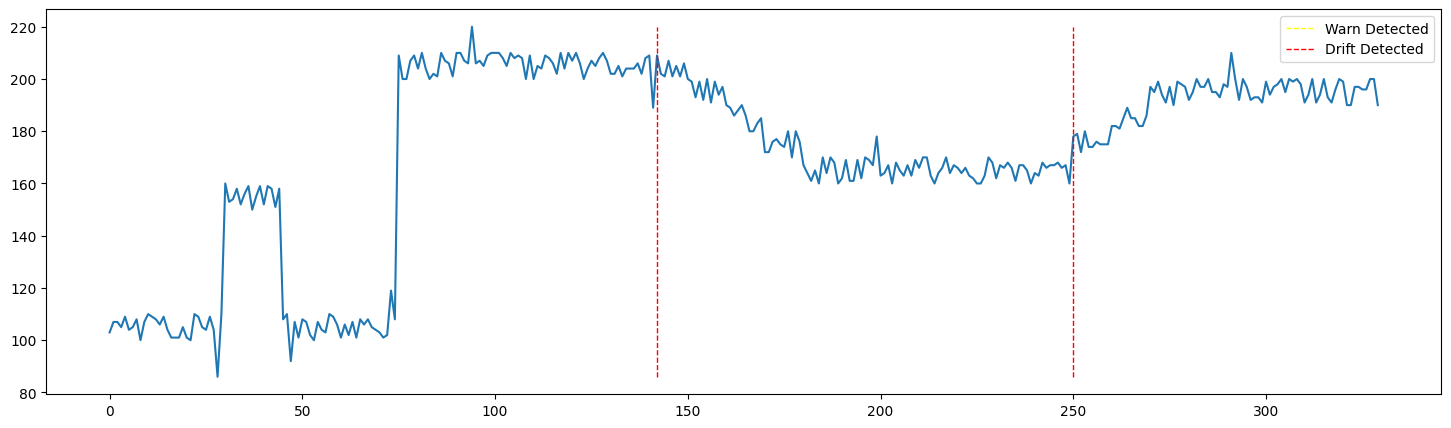

In [266]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(flat)

drift_l = np.where(drifts == 1)[0]
warns_l = np.where(warns == 1)[0]

ax.vlines(warns_l, ymin=min(flat), ymax=max(flat),
          color='yellow', linestyle='--', linewidth=1, label='Warn Detected')
ax.vlines(drift_l, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

### EDDM

In [267]:
eddm = EDDM()
correct = (error > 0.1).astype(int)

warns = np.array([0 for i in range(101)])
drifts = np.array([0 for i in range(101)])

for i, c in enumerate(correct):
    eddm.update(c)
    if eddm.warning_detected:
        warns = np.append(warns, 1)
    else:
        warns = np.append(warns, 0)
    if eddm.drift_detected:
        drifts = np.append(drifts, 1)
    else:
        drifts = np.append(drifts, 0)

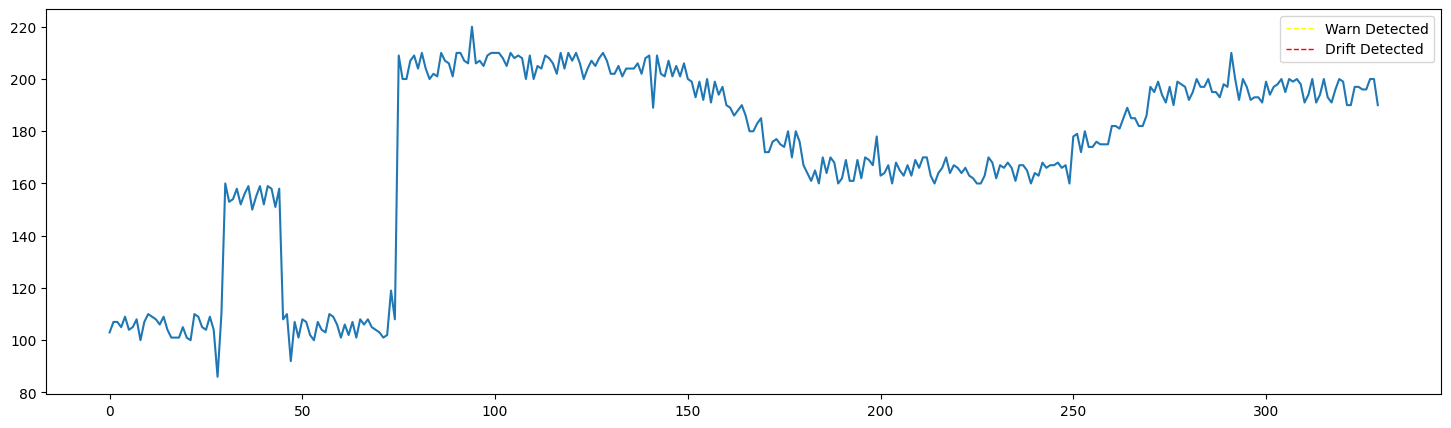

In [274]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(flat)

drift_l = np.where(drifts == 1)[0]
warns_l = np.where(warns == 1)[0]

ax.vlines(warns_l, ymin=min(flat), ymax=max(flat),
          color='yellow', linestyle='--', linewidth=1, label='Warn Detected')
ax.vlines(drift_l, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

### Anomalies Types

#### Point Anomalies
A point anomaly is a single instance of data that is too far off from the rest. This occurs when a particular data sample significantly differs from the distribution of the data. For example, in credit card fraud detection, the purchase of a high-value item can be considered a point anomaly.

<!-- <img src="point_anomalie.png"> -->


#### Contextual Anomalies
Contextual anomalies refer to data points that deviate significantly within a specific context but appear normal outside of that context. For example, high network bandwidth usage during regular office hours might be standard due to employees accessing cloud services and collaborating online. However, the same level of bandwidth usage late at night, when the office is expected to be closed, would be regarded as a contextual anomaly. Such an anomaly could suggest unauthorized access or a malfunctioning device.

<!-- <img src="contextual_anomalie.png" height="50px"> -->

#### Collective Anomalies
Collective anomalies involve a set of data points that, when considered together, deviate from what is expected, even though individual points may not qualify as anomalies. For instance, multiple small transactions made repeatedly by someone to evade detection would form a collective anomaly.

<!-- <img src="collective_anomalie.png" height="50px"> -->

https://victoriametrics.com/blog/victoriametrics-anomaly-detection-handbook-chapter-2/

https://medium.com/@valievkoyiljon112/mastering-anomaly-detection-a-deep-dive-into-techniques-and-industry-applications-92d2ae1923b8

https://hackernoon.com/3-types-of-anomalies-in-anomaly-detection

https://www.ibm.com/think/topics/anomaly-detection

In [321]:
flat = data.flatten()

### Fixed windows size method

Nessa abordagem iremos, ao encontrar uma anomalia avaliar se aquele registro seria uma anomalia uma janela para frente dos dados

##### To Do
- Mudar o local onde inserimos o dado na janela seguinte a que estamos analisando no momento
- Testar em algum local onde temos uma deriva
- Testar em algum local onde temos uma anomalia coletiva

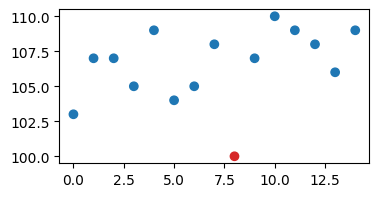

In [323]:
# Identificando anomalias dentro de uma janela

data_samp = flat[:batch_size]

X = data_samp.reshape(-1, 1)
dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X)

anomalies = data_samp[np.where(clusters == -1)]

fig, ax = plt.subplots(figsize=(4, 2))

color = ['#d62728' if cl == -1 else '#1f77b4' for cl in clusters]

ax.scatter(range(len(data_samp)), data_samp, c=color, marker='o')

plt.show()

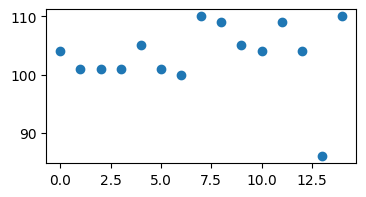

In [324]:
# Analisando a próxima janela

data_samp_future_window = flat[batch_size:batch_size*2]

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(range(len(data_samp_future_window)), data_samp_future_window, marker='o')

plt.show()

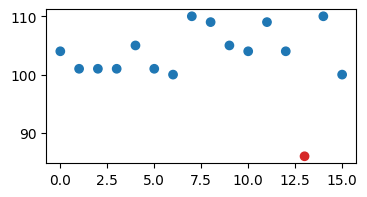

In [325]:
# Avaliando se anomalias passadas são anomalias dentro dessa nova jenela

fig, axes = plt.subplots(len(anomalies), 1, figsize=(4, 2))

data_test = np.append(data_samp_future_window, anomalies[0])

X = data_test.reshape(-1, 1)
dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X)

color = ['#d62728' if cl == -1 else '#1f77b4' for cl in clusters]

axes.scatter(range(len(data_test)), data_test, c=color, marker='o')

plt.show()


### Fixed Window size method

Agora iremos testar os dados de uma janela posterior em relacao a janela onde encontramos a anomalia, de maneira que iremos manter as estatisticas da janela onde encontramos a anomalia, assim identificando se a janela posterior se adapta a janela anterior

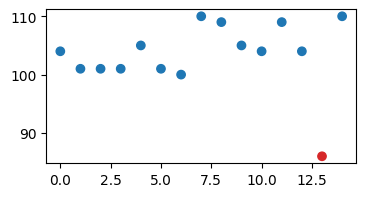

In [327]:
# Identificando anomalias dentro de uma janela usando estatística e não dbscan

data_samp = flat[batch_size:batch_size*2]

outliers = outlierDetector(data_samp)

fig, ax = plt.subplots(figsize=(4, 2))

color = ['#d62728' if o else '#1f77b4' for o in outliers]

ax.scatter(range(len(data_samp)), data_samp, c=color, marker='o')

plt.show()

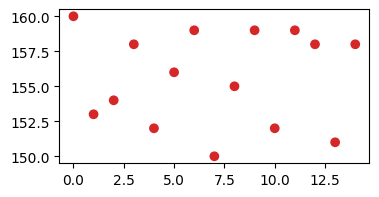

In [328]:
# Analisando a janela seguinte utilizando os parämetros da janela anterior

iqr, q25, q75, upper_bound, lower_bound = getOutlierDetectorParams(data_samp)

data_samp_future_window = flat[batch_size*2:batch_size*3]

outliers = np.where((data_samp_future_window > upper_bound) | (data_samp_future_window < lower_bound) , True, False)

fig, ax = plt.subplots(figsize=(4, 2))

color = ['#d62728' if o else '#1f77b4' for o in outliers]

ax.scatter(range(len(data_samp_future_window)), data_samp_future_window, c=color, marker='o')

plt.show()


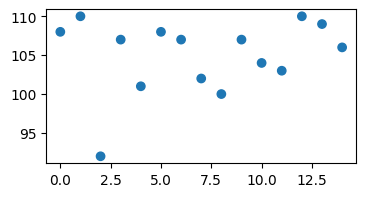

In [329]:
# Analisando a terceira janela, onde os dados voltaram ao normal

data_samp_normal_future_window = flat[batch_size*3:batch_size*4]

outliers = np.where((data_samp_normal_future_window > upper_bound) | (data_samp_normal_future_window < lower_bound) , True, False)

fig, ax = plt.subplots(figsize=(4, 2))

color = ['#d62728' if o else '#1f77b4' for o in outliers]

ax.scatter(range(len(data_samp_normal_future_window)), data_samp_normal_future_window, c=color, marker='o')

plt.show()

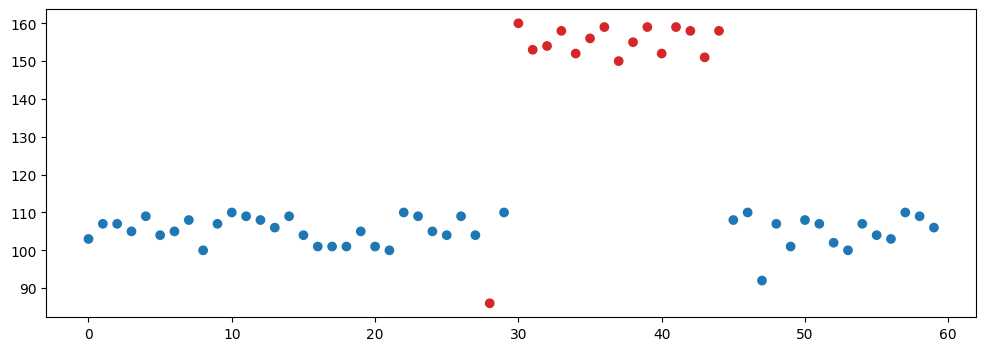

In [333]:
fig, ax = plt.subplots(figsize=(12, 4))

outliers = np.where((flat[:batch_size*4] > upper_bound) | (flat[:batch_size*4] < lower_bound) , True, False)

color = ['#d62728' if o else '#1f77b4' for o in outliers]

ax.scatter(range(len(flat[:batch_size*4])), flat[:batch_size*4], c=color,  marker='o')

plt.show()

### Mean method

Nesse método iremos avaliar utilizando a média dos registros dentro de uma janela, de maneira que, se a deriva observada na verdade for uma anomalia de coletiva, utilizando uma média aquele anomalia coletiva sera identificada como anomalia e não como deriva

_Dificuldades com essa abordagem_
- Como definir a janela de agrupamento dos dados?

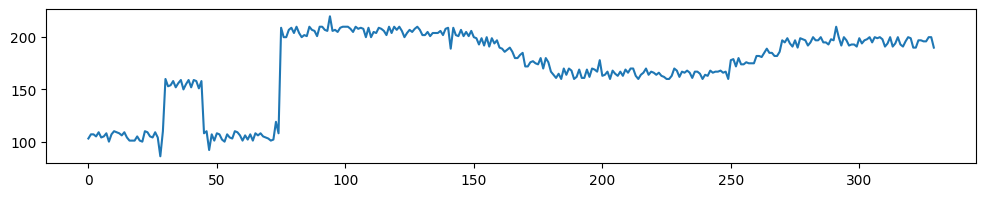

In [340]:
flat_samp = flat

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(flat_samp)

plt.show()

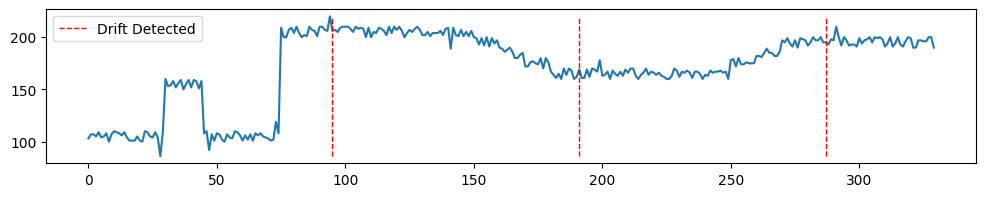

In [341]:
adwin = drift.ADWIN()

drifts = np.array([])

for d in flat_samp:
  adwin.update(d)

  if adwin.drift_detected:
    drifts = np.append(drifts, 1)
  else:
    drifts = np.append(drifts, 0)

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(flat_samp)

lines = np.where(drifts == 1)[0]
ax.vlines(lines, ymin=min(flat_samp), ymax=max(flat_samp),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

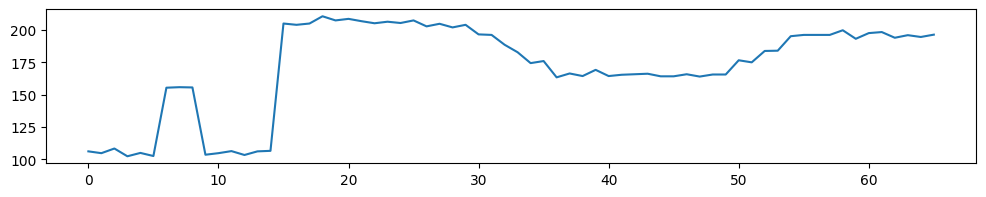

In [342]:
flat_5_window = flat_samp.reshape(-1, 5)

flat_5_window_mean = np.mean(flat_5_window, axis=1)

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(flat_5_window_mean)

plt.show()

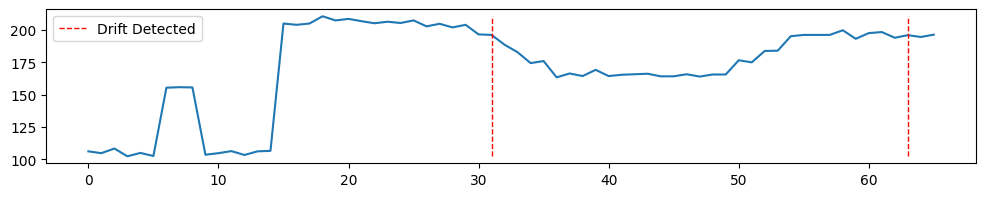

In [343]:
adwin = drift.ADWIN()

drifts = np.array([])

for d in flat_5_window_mean:
  adwin.update(d)

  if adwin.drift_detected:
    drifts = np.append(drifts, 1)
  else:
    drifts = np.append(drifts, 0)

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(flat_5_window_mean)

lines = np.where(drifts == 1)[0]
ax.vlines(lines, ymin=min(flat_5_window_mean), ymax=max(flat_5_window_mean),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

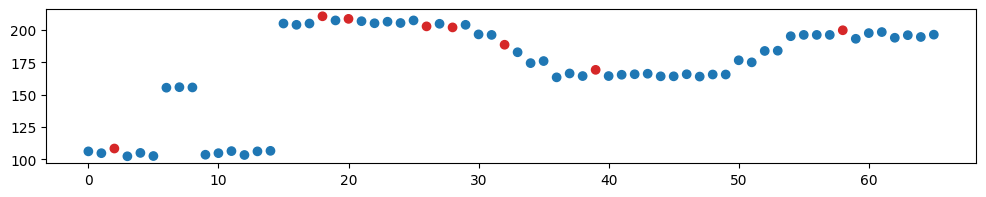

In [345]:
X = flat_5_window_mean.reshape(-1, 1)
dbscan = DBSCAN(eps=1, min_samples=3)
clusters = dbscan.fit_predict(X)

anomalies = flat_5_window_mean[np.where(clusters == -1)]

fig, ax = plt.subplots(figsize=(12, 2))

color = ['#d62728' if cl == -1 else '#1f77b4' for cl in clusters]

ax.scatter(range(len(flat_5_window_mean)), flat_5_window_mean, c=color, marker='o')

plt.show()